# Satellite Coverage Analysis

The coverage of a single satellite determines its throughput of data and capacity. The time in which a satellite is visible and available for communication is usually referred to as "Overpass" . Knowing the coverage of a satellite and its overpasses for different regions of the world gives insight on the entire constellation.

In [48]:
import numpy as np
import math
import matplotlib.pyplot as plt
from functools import partial
import h3
from descartes import PolygonPatch

# Setting global font to "CMU Sans Serif"
from matplotlib import rcParams
rcParams["font.family"] = "CMU Sans Serif"

# This will compile plots to be Latex compatible
plt.rc('text', usetex=True)

## Coverage Geometry

The visibility geometry of the coverage consists of four variables:

- $\varepsilon$: Elevation Angle
- $\alpha$: Nadir Angle. From the satellite, angle between Nadir and direction to ground stations
- $\beta$: Central Angle
- $d$: Slant Range

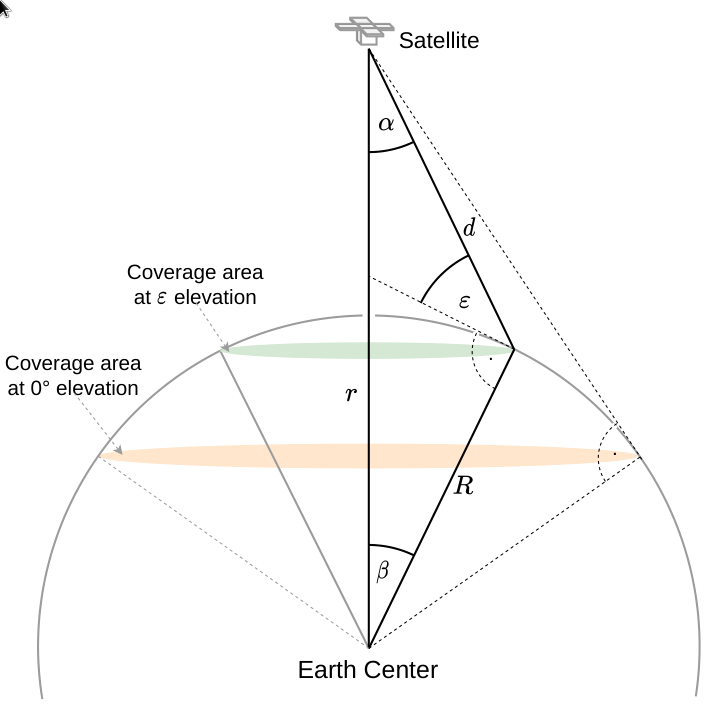

The value $r$, which is the sum of altitude and earth radius $R$, is determined by the chosen orbital parameters.
The parameter of slant range $d$ is used for the link budget calculation. Often, a minimum of 10° elevation angle is used. The four mentioned parameters above are correlated with following equations:

\begin{align}
\varepsilon + \alpha + \beta &= 90\\
d \cos{(\varepsilon)} &= r \sin{(\beta)}\\
d \sin{(\alpha)} &= R \sin{(\beta)}
\end{align}
(source: "Principles of communication satellites" 1993 by G.D. Gordin)

We are often interested in the radius of the coverage area based on altitude and elevation.
There are two ways to define radius: the radius of the slice depicted in the image above (A), or the geodesic distance (arc length) (B). For both radius measures, we need to solve for beta. First, we can determine the slant range d using the Cosine Law.

\begin{align}
r^2 = R^2 + d^2 - 2Rd\cdot \cos{(90 + \varepsilon)}
\end{align}

We can solve this using the geometric formula.

\begin{align}
B &= -(2R \cdot \cos{(90 + \varepsilon)}) \\
C &= R^2 - r^2 \\
d &= \frac{-B + \sqrt{B^2 - 4C}}{2}
\end{align}

Using the slant range we can the other four parameters. In the following, we show a plot of elevation to coverage radius

In [29]:
# We are often interested in the radius of the coverage area based on altitude and elevation.
# There are two ways to define radius: the radius of the slice depicted in the image above (A), or the geodesic distance (arc length) (B)

def slant_distance(e, h, R = 6371):
    """
    Computes the slant distance based on elevation and altitude.
    
    e: Elevation in degrees
    h: Altitude in km
    
    Returns
    
    d: slant distance in km
    """
    B = -2 * R * np.cos(np.radians(90 + e))
    C = -2 * R * h - h**2
    # Solving a geometric equation where only one is real
    d = (-B + np.sqrt(B**2 - 4*C)) / 2.0
    return d

def params(e, h, R = 6371):
    """
    With the equations above, we can solve all four parameters
    
    e: Elevation in degrees
    h: Altitude in km
    
    Returns
    
    all four parameters discussed above
    """
    r = R + h
    
    d = slant_distance(e, h, R=R)
    beta = np.degrees( np.arcsin( d * np.cos(np.radians(e))/r ) )
    alpha = 90 - e - beta
    
    return e, alpha, beta, d

def coverage_radius_A(e, h, R = 6371):
    """
    With the equations above, we can solve all four parameters
    
    e: Elevation in degrees
    h: Altitude in km
    
    Returns
    
    Radius A in km
    """
    _, _, beta, _ = params(e, h, R=R)
    radius = np.sin(np.radians(beta)) * R
    return radius

def coverage_radius_B(e, h, R = 6371):
    """
    With the equations above, we can solve all four parameters
    
    e: Elevation in degrees
    h: Altitude in km
    
    Returns
    
    Radius B in km
    """
    _, _, beta, _ = params(e, h, R=R)
    diameter = 2 * np.pi * R
    radius = (beta / 360) * diameter
    return radius

The following plot show how radius A and B is almost negligible

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [53]:
_, _, beta, slant_distances = params(np.arange(0, 30, 1), 550)
ys = beta + 53

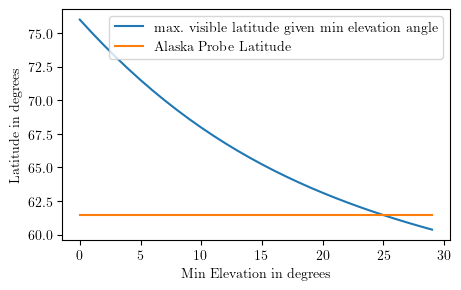

In [57]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(np.arange(0, 30, 1), ys, label="max. visible latitude given min elevation angle")
ax.plot(np.arange(0, 30, 1), [61.5] * len(np.arange(0, 30, 1)), label="Alaska Probe Latitude")
ax.set_xlabel("Min Elevation in degrees")
ax.set_ylabel("Latitude in degrees")

#ax2 = ax.twinx()
#ax2.plot(np.arange(0, 30, 1), slant_distances, label="slant distance", color="r")

ax.legend()

plt.show()

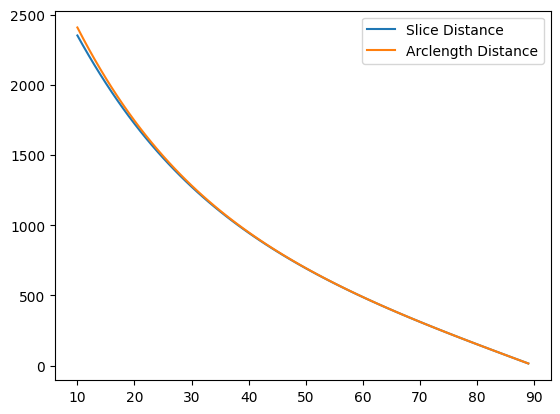

In [16]:
H = 1000
crA500 = partial(coverage_radius_A, h=H)
crB500 = partial(coverage_radius_B, h=H)

xs = np.arange(10, 90, 1)
yA = crA500(xs)
yB = crB500(xs)

plt.plot(xs, yA, label="Slice Distance")
plt.plot(xs, yB, label="Arclength Distance")
plt.legend()
plt.show()

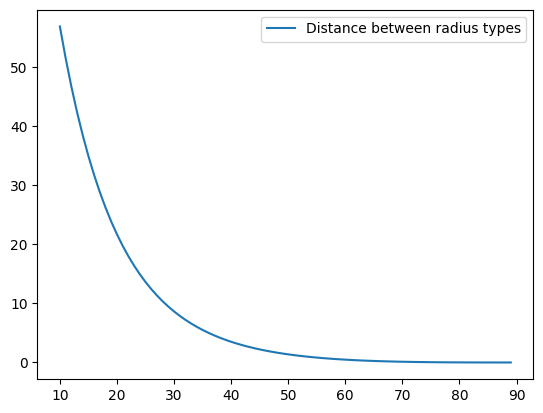

In [17]:
plt.plot(xs, yB-yA, label="Distance between radius types")
plt.legend()
plt.show()

Fun fact, if you see coverage plots of a satellite over a map, it usually is distorted through the map projection type used.

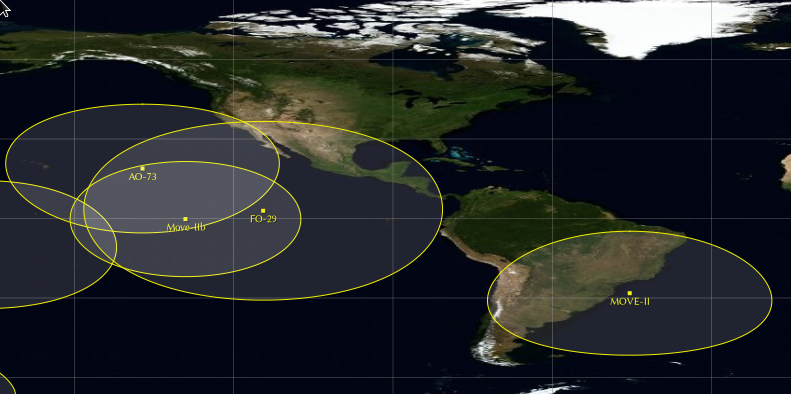

To conclude, we can say that with a minimal elevation of 15°, a starlink satellite at 550km elevation has a coverage radius of ~1360km

## Coverage Analysis depending on inclination

In this coverage analysis we project the groundtrack of an orbit and show the coverage of the groundtrack based on inclination and 15° minimum elevation.

In [18]:
from pymap3d.ecef import eci2geodetic
from datetime import datetime
from functools import partial
from scipy.spatial.transform import Rotation as R
import geopandas
import cartopy.crs as ccrs
from matplotlib import colors
import matplotlib.pyplot as plt

In [19]:
def get_orbitecis(incl, raan, altitude, n, begin_time=0, Earth_R=6371, portion=1.0):
    """Generates a circular orbit based on given parameters
    
    Params:
        incl: Inclination in Degrees
        raan: Right Ascension to Ascending Node in Degrees
        altitude: Altitude in km
        n: amount of points needed for a full revolution
        begin_time: time in which to begin
        portion: ratio of the portion of points to be created
    
    Returns:
        A tuple
        (
            np array of r_eci points in km,
            np array of v_eci in km/s,
            delta seconds since beginning)
    """
    
    # Calculating r_eci
    points = []
    for i in range(int(n*portion)):
        points.append([np.sin(2*np.pi * (i/n)), np.cos(2*np.pi * (i/n)), 0])
    points = np.array(points) * (altitude + Earth_R)  # Plus height in km
    
    m_raan = R.from_rotvec(np.array([0, 0, 1]) * raan, degrees=True).as_matrix()  # Rotation along the north-pole axis
    m_incl = R.from_rotvec(np.array([1, 0, 0]) * incl, degrees=True).as_matrix()  # Rotation along the axis towards the ascending node
    
    raan_vec = np.matmul(m_raan, np.array([1, 0, 0]))
    incl_vec = np.matmul(m_incl, np.array([0, 1, 0]))
    incl_vec = np.matmul(m_raan, incl_vec)
    normal = np.cross(raan_vec, incl_vec)
    basechange_m = np.array([raan_vec, incl_vec, normal])
    
    r_ecis = np.matmul(basechange_m.T, points.T).T
    
    # Calculating Time periods
    mu = 398600.4418 # unit: (km)^3 / s^2
    period_s = ((2*np.pi) / np.sqrt(mu)) * np.sqrt(altitude + Earth_R)**3 # Period of one revolution
    delta_array = np.arange(0, period_s, period_s/n)
    time_array = [datetime.fromtimestamp(dt + begin_time) for dt in delta_array]
    
    # Calculating v_eci in km/s
    velocity = (2 * np.pi * (altitude + Earth_R)) / period_s
    v_ecis = []
    for r_eci in r_ecis:
        v_eci_ = np.cross(-r_eci, normal)
        v_eci_ = v_eci_ / np.linalg.norm(v_eci_)
        v_eci_ *= velocity
        v_ecis.append(v_eci_)
    v_ecis = np.array(v_ecis)
    
    return r_ecis, v_ecis, time_array

def get_bounding_points(r_eci, v_eci, time, min_elevation=15):
    """
    Given a eci point, we calculate the bounding points of its coverage based
    on min_elevation in degrees.
    
    r_eci: point in ECI coordinates
    v_eci: vector tangential forward, also can be seen as velocity
    min_elevation: minimum elevation, for coverage
    
    returns upperbounding point, lowerbounding point as lat long coordinates
    """
    altitude = np.linalg.norm(r_eci) - 6371
    _, _, beta, _ = params(min_elevation, altitude, R = 6371)
    rot_m = R.from_rotvec(v_eci * np.radians(beta) / np.linalg.norm(v_eci)).as_matrix()
    
    bounding_reci1 = np.matmul(rot_m, r_eci)
    bounding_reci2 = np.matmul(np.linalg.inv(rot_m), r_eci)
    
    lat1, long1, _ = eci2geodetic(*(bounding_reci1 * 1000), time)
    lat2, long2, _ = eci2geodetic(*(bounding_reci2 * 1000), time)
    return ((lat1, long1), (lat2, long2))

def get_coords(incl, raan, altitude, n, begin_time=0, portion=1.0):
    """Generates ground track of a  circular orbit based on given parameters
    
    Params:
        incl: Inclination in Degrees
        raan: Right Ascension to Ascending Node in Degrees
        altitude: Altitude in km
        n: amount of points to be generated
        begin_time: time in which to begin
    
    Returns:
        array of lat long tuples
    """
    ps, vs, ts = get_orbitecis(incl, raan, altitude, n, begin_time, portion=portion)
    
    coords = []
    bound_coords1 = []
    bound_coords2 = []
    for point, fwd, time in zip(ps, vs, ts):
        lat, long, altitude = eci2geodetic(*(point * 1000), time)
        coords.append((lat[0], long[0]))
        bc1, bc2 = get_bounding_points(point, fwd, time)
        bound_coords1.append(bc1)
        bound_coords2.append(bc2)
    return np.array(coords), np.array(bound_coords1), np.array(bound_coords2)

# partitioning a coordinate list based on continuities
def discontin_partition(coord_list):
    latitude, longitude = coord_list[:, 0], coord_list[:, 1]
    coords_list_ = [(latitude, longitude)]
    last_long = 0
    for i, long in enumerate(longitude):
        if (np.abs(long - last_long) > 200):
            coords_list_ = [(coord_list[:i, 0], coord_list[:i, 1])]
            coords_list_.append((coord_list[i:, 0], coord_list[i:, 1]))
            break
        else:
            last_long = long
    return coords_list_

# Plotting GS points
def plot_period_groundtrack(coord_list, ax, color, label=""):
    coords_list = discontin_partition(coord_list)
    for lats, longs in coords_list:
        ax.plot(longs, lats,
                   color=color,
                   zorder = 10,
                   linewidth = 0.7, label=label)
        label = ""

def construct_polygon(bound_coords1, bound_coords2):
    """Constructing polygon based on bounding coords.
    
    We are working with the following assumptions about the coordinates:
    - they are contiguously ordered
    - they do one revolution around the longitude coordinates
    
    This is a rather quick and dirty solution but it somewhat works, so year. The resulting polygon might have some weird
    zizags
    """
    def get_longitude(c):
        return c[1]
    bound_coords1 = sorted(bound_coords1, key=get_longitude)
    bound_coords2 = sorted(bound_coords2, key=get_longitude, reverse=True)
    polygon = np.array([*bound_coords1, *bound_coords2])
    return polygon

def plot_bounds(bound_coords1, bound_coords2, ax, color):
    bound_polygon = construct_polygon(bound_coords1, bound_coords2)
    ax.fill(bound_polygon[:, 1], bound_polygon[:, 0], facecolor=color)

In [20]:
# Retrieving Starlink Availability scraped from wikipedia
from bs4 import BeautifulSoup
import requests

response = requests.get("https://en.wikipedia.org/wiki/Starlink")
soup = BeautifulSoup(response.text)

countries_soup = soup.find_all("table", attrs={"class": "wikitable"})[1]

countries = []
for a in countries_soup.find_all("tr")[1:]:
    for b in a.find_all("td")[2].find_all("a"):
        countries.append(b.text)

In [58]:
from bs4 import BeautifulSoup

def process_kml(file_path):
    with open(file_path, "r") as f:
        kml_str = f.read()
    soup = BeautifulSoup(kml_str, "xml")
    return soup
        
file_path = "./data/Gateways_PoPs_n_Backbone.kml"

soup = process_kml(file_path)

In [60]:
import pandas as pd

gateway_locs = []
for f in soup.find_all("Folder"):
    if(f.find("name").text == "PoPs & Backbone"):
        continue
    continent = f.find("name").text
    for pm in f.find_all("Placemark"):
        gateway_locs.append((continent, pm))

def parse_pm_gw(continent, pm):
    d = {}
    lat, lon = pm.find("Data", attrs={"name" : "Coords"}).find("value").text.split(",")
    lat = float(lat.strip())
    lon = float(lon.strip())
    d["continent"] = continent
    d["lat"] = lat
    d["long"] = lon
    return d
    
gateway_locs = [parse_pm_gw(cont, gl) for (cont, gl) in gateway_locs]
gateway_df = pd.DataFrame(gateway_locs)

In [61]:
pop_locs = []
for f in soup.find_all("Folder"):
    if(f.find("name").text != "PoPs & Backbone"):
        continue
    for pm in f.find_all("Placemark"):
        if(f.find("styleUrl").text != "#icon-1609-0288D1"):
            continue
        #print(pm)
        if(pm == None):
            print(f)
        pop_locs.append(pm)

def parse_pm_pop(pm):
    d = {}
    #print(pm.find("coordinates").text.split(","))
    coordinates = pm.find("coordinates").text.split(",")
    lat = float(coordinates[1].strip())
    lon = float(coordinates[0].strip())
    d["lat"] = lat
    d["long"] = lon
    return d
    
pop_locs = [parse_pm_pop(pl) for pl in pop_locs]
pop_df = pd.DataFrame(pop_locs)

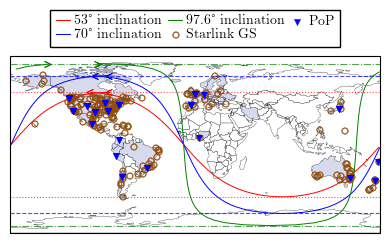

In [90]:
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(4, 2.6), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "white", edgecolor="black", ax=ax, linewidth=0.2)



def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.2, zorder=2, linewidth=0.0 ))

for c in countries:
    c = "United States of America" if c == "United States" else c
    c = "Czechia" if c == "Czech Republic" else c
    
    if(c in world["name"].values):
        plotCountryPatch(ax, c, "#364aa0")

begin_time = 1679408909

coords, bc1, bc2 = get_coords( 53, 238, 550, 100, begin_time, portion=1)
plot_period_groundtrack(coords,  ax, "red", label="53° inclination")
to_scatter = [coords[0], coords[-1]]
ax.scatter(
            [latlon[1] - 2 for latlon in to_scatter],
            [latlon[0] for latlon in to_scatter], 
            marker='$<$', zorder=10, color="red", sizes=[30.0], linewidth=0.5)
#plot_bounds(bc1_40, bc2_40, ax, "#436abc48")

coords, bc1, bc2 = get_coords( 70, 238, 570, 100, begin_time, portion=1)
plot_period_groundtrack(coords, ax, "blue", label="70° inclination")
to_scatter = [coords[0], coords[-1]]
ax.scatter(
            [latlon[1] - 2 for latlon in to_scatter],
            [latlon[0] for latlon in to_scatter], 
            marker='$<$', zorder=10, color="blue", sizes=[30.0], linewidth=0.5)
#plot_bounds(bc1_80, bc2_80, ax, "#9cd37a48")

coords, bc1, bc2 = get_coords( 97.6, 46, 560, 100, begin_time, portion=1)
plot_period_groundtrack(coords, ax, "green", label="97.6° inclination")
to_scatter = [coords[0], coords[-1]]
ax.scatter(
            [latlon[1] for latlon in to_scatter],
            [latlon[0] for latlon in to_scatter], 
            marker='$>$', zorder=10, color="green", sizes=[30.0], linewidth=0.5)

#coords_80, bc1_80, bc2_80 = get_coords( 98, 238, 500, 100, begin_time)
#plot_period_groundtrack(coords_80, ax, "green", label="75° inclination")
#plot_bounds(bc1_80, bc2_80, ax, "#9cd37a48")
    
def plot_extent(inclination, color="r", lw=1.4, alpha=0.7, lt="dotted"):
    #label = "{}°".format(inclination)
    label=""
    if inclination > 90:
        inclination = 90 - (inclination % 90)
    plt.plot([-180, 180], [ inclination,  inclination], linewidth=lw, color=color, linestyle=lt, alpha=alpha, label=label)
    plt.plot([-180, 180], [-inclination, -inclination], linewidth=lw, color=color, linestyle=lt, alpha=alpha)

plot_extent(53, "r", lt="dotted", lw=0.8)
plot_extent(70, "b", lt="dashed", lw=0.8)
plot_extent(97.6, "g", lt="dashdot", lw=0.8)


# Plotting GS points
def plot_gsdata(gsdata_df, ax, label, marker, color, size=10, lw=0.6):
    latitude, longitude = gsdata_df["lat"], gsdata_df["long"]
    ax.scatter(longitude, latitude,
               sizes = [size],
               color=color,
               zorder = 10,
               marker=marker,
               linewidth = lw,
               label=label)
 
    
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

#ax2.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
#ax2.get_xaxis().set_ticks([])
#ax2.get_yaxis().set_ticks([])

#legend1 = plt.legend(plot_lines[0], ["algo1", "algo2", "algo3"], loc=1)
#pyplot.legend([l[0] for l in plot_lines], parameters, loc=4)

#ax2 = ax.twinx()
plot_gsdata(gateway_df, ax, "Starlink GS", "$\circ$", cols[4], 30, lw=0.3)
plot_gsdata(pop_df, ax, "PoP", "v", "blue", 20, lw=0.3)

#plt.legend(loc='upper right', bbox_to_anchor=(1.01, 1.03),
#          ncol=1, fancybox=True, shadow=False, framealpha = 1.0)
ax.legend(loc='upper center', bbox_to_anchor=(0.50, 1.30),
        ncol=3, edgecolor="k", handlelength=1, labelspacing=0.06, 
        columnspacing=0.5, fancybox=False, shadow=False, handletextpad = 0.3, framealpha = 1.0).set_zorder(100)
#ax2.legend(loc='lower left',
#        ncol=1, edgecolor="k", handlelength=1, labelspacing=0.06, 
#        columnspacing=0.5, fancybox=False, shadow=False, handletextpad = 0.3, framealpha = 1.0).set_zorder(100)

#ax.legend(loc="upper center", bbox_to_anchor=(0.50, 1.25), frameon=False, shadow=False,
#              ncol=5,
#              labelspacing=0.3, handlelength=1.2, handletextpad=0.4, columnspacing=1.2)

plt.axis('tight')
plt.tight_layout()
plt.savefig("figures/inclination_starlink_comparison_with_gws.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

## Coverage of an Orbital Plane

With the code and geometry of previous section, we know the coverage of a satellite given its position, minimum elevation angle and altitude. Now, we can analyze the coverage of one orbital plane, so satellites sharing the inclination and altitude. (Since we are doing LEO satellites, we reduce the DOF of orbital parameters)

- We want area coverage plots of the orbital planes

- curve plots of the orbits on the plane

## ISL Length

The maximum ISL Length is determined by the start of the mesosphere, which introduces major attenuation. The following figure taken from: _Bhattacherjee, Debopam, and Ankit Singla. "Network topology design at 27,000 km/hour." 2019._

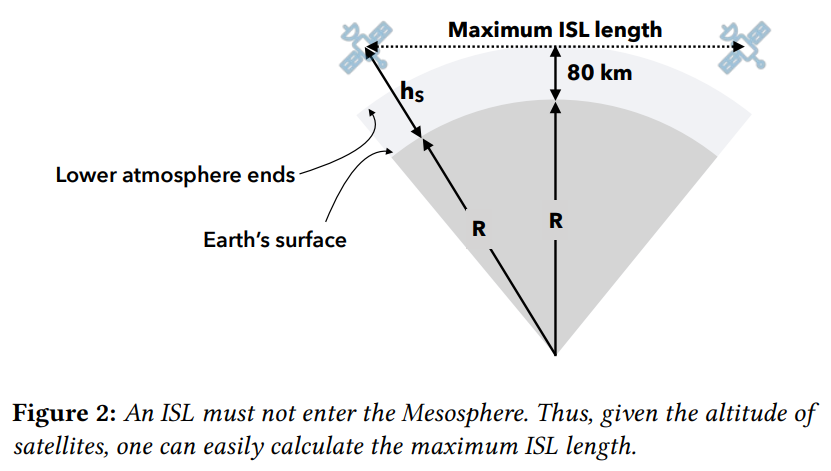

In [351]:
from scipy.spatial.transform import Rotation as R

In [367]:
def max_isl_length(h, R = 6371):
    """Calculate max isl length based on altitude h in km
    """
    len_half = np.sqrt((R + h)**2 - (R + 80)**2)
    return 2*len_half

def maximum_interplane_distance(inclination_deg, altitude_km, planes, is_walker_star=True, distance=1):
    vec_ref = np.array([0, 1, 0])
    if(is_walker_star):
        raan_deg = (360 / planes) * distance
    else:
        raan_deg = (180 / planes) * distance
    rot1 = R.from_rotvec(np.array([0, 0, inclination_deg]), degrees=True)
    rot2 = R.from_rotvec(np.array([0, raan_deg, 0]), degrees=True)
    
    vec1 = np.matmul(rot1.as_matrix(), vec_ref)
    vec2 = np.matmul(rot2.as_matrix(), np.matmul(rot1.as_matrix(), vec_ref))
    
    def angle(v1, v2):
        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        return angle
    
    alpha = angle(vec1, vec2)    
    return 2*(altitude_km + 6371)*np.sin(alpha/2)

def mean_intraplane_distance(altitude_km, n_satellites, distance=1):
    alpha = (360 / n_satellites) * distance
    return 2*(altitude_km + 6371)*np.sin(np.radians(alpha)/2)

In [377]:
inclination_deg = 86.4
altitude_km = 660
n_planes = 6
n_satellites = 11 # Per Plane
is_walker_star = False
inter_distance = 1
intra_distance = 1

print("Maximum ISL Length (km)\t\t:", max_isl_length(altitude_km))
print("Maximum Inter-Plane Distance\t:", maximum_interplane_distance(inclination_deg, altitude_km, n_planes, is_walker_star=is_walker_star, distance=inter_distance))
print("Mean Intra-Plane Distance\t:", mean_intraplane_distance(altitude_km, n_satellites, distance=intra_distance))

Maximum ISL Length (km)		: 5592.695235751721
Maximum Inter-Plane Distance	: 3632.3316638803626
Mean Intra-Plane Distance	: 3961.7232143041842


In [378]:
inclination_deg = 53.0
altitude_km = 550
n_planes = 72
n_satellites = 22 # Per Plane
is_walker_star = True
inter_distance = 1
intra_distance = 1

print("Maximum ISL Length (km)\t\t:", max_isl_length(altitude_km))
print("Maximum Inter-Plane Distance\t:", maximum_interplane_distance(inclination_deg, altitude_km, n_planes, is_walker_star=is_walker_star, distance=inter_distance))
print("Mean Intra-Plane Distance\t:", mean_intraplane_distance(altitude_km, n_satellites, distance=intra_distance))

Maximum ISL Length (km)		: 5013.916632733337
Maximum Inter-Plane Distance	: 482.19979678562584
Mean Intra-Plane Distance	: 1969.921991378813
